In [9]:
import cell2cell as c2c
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import skbio

%matplotlib inline

# Analysis Setup

Here, all inputs and parameters needed for the analysis are defined

**Location of files**

In [10]:
files = dict()
files['rnaseq'] = '../data/CElegans_RNASeqData_Cell.xlsx'
files['ppi'] = '../data/CElegans_PPIs_RSPGM.xlsx'
files['go_annotations'] = '../data/wb.gaf.gz'
files['go_terms'] = '../data/go-basic.obo'
files['output_folder'] = '../outputs/'

**RNA-seq data manipulation**

- <font color="green">'gene_col'</font> is the name of the column containing the list or names of genes in the dataset.
- <font color="green">'drop_nangenes'</font> is a boolean decision to remove those genes with NaN values.
- <font color="green">'log_transform'</font> is a boolean decision to log-transform the dataset.

In [11]:
rnaseq_setup = dict()
rnaseq_setup['gene_col'] = 'gene_id'
rnaseq_setup['drop_nangenes'] = True
rnaseq_setup['log_transform'] = False

**Columns for PPI network**

- <font color="green">'protein_cols'</font> is a list containing the names of the first and second interactors.

In [12]:
ppi_setup = dict()
ppi_setup['protein_cols'] = ['WormBase_ID_a', 'WormBase_ID_b']

**Cutoffs setup for binarizing gene expression**

- <font color="green">'type'</font> is the type of cutoff to use. So far, only 'local_percentile' and 'global_percentile' are implemented.
- <font color="green">'parameter'</font> is the corresponding parameter for the type of cutoff. If percentile is used, it should be a value between 0 and 1. E.g. a value of 0.8 represents the 80-th percentile.

In [13]:
cutoff_setup = dict()
cutoff_setup['type'] = 'local_percentile'
cutoff_setup['parameter'] = 0.8 

**GO annotation and terms to filter PPI network**

- <font color="green">'experimental_evidence'</font> is a boolean decision to consider only GO annotations of genes that have experimental support (e.g. associated articles).
- <font color="green">'descendants'</font> is a boolean decision to consider the GO terms that are children of a given GO term (based on their hierarchy).

In [14]:
go_setup = dict()
go_setup['experimental_evidence'] = True
go_setup['descendants'] = True

**General Analysis setups**

- <font color="green">'interaction_type'</font> is the type of intercellular interaction to analyze. It could be 'contacts', 'mediated', or 'combined'. The last one considers 'contacts' and 'mediated' together.
- <font color="green">'function_type'</font> is the type of function to calculate the interaction index for a pair of cells. It could be 'binary' to use 0 or 1 values of gene expression depending on a cutoff value for each one or 'sample_weighted' to use a continue value between 0 and 1 given the maximal expression level of each gene.
- <font color="green">'subsampling_space'</font> is the ratio of cells to be randomly considered in each iteration to compute the interactions. Here, iterations are used especially when using percentile cutoff, to avoid enrichment for cell types with high expression levels of certain genes.
- <font color="green">'iterations'</font> is the number of iterations to perform different random subsamplings.
- <font color="green">'cpu_cores'</font> is the number of cores to use and run parallelly the iterations for subsampling.

In [15]:
analysis_setup = dict()
analysis_setup['interaction_type'] = ['contacts', 'mediated', 'combined']
analysis_setup['function_type'] = 'binary'
analysis_setup['subsampling_percentage'] = 0.8
analysis_setup['iterations'] = 1000
analysis_setup['cpu_cores'] = 7 # To enable parallel computing

# Load Data

**RNA-seq**

In [16]:
rnaseq_data = c2c.io.load_rnaseq(rnaseq_file=files['rnaseq'],
                                 gene_column=rnaseq_setup['gene_col'],
                                 drop_nangenes=rnaseq_setup['drop_nangenes'],
                                 log_transformation=rnaseq_setup['log_transform'],
                                 format='auto')

Opening RNAseq data from ../data/CElegans_RNASeqData_Cell.xlsx
../data/CElegans_RNASeqData_Cell.xlsx was correctly loaded


**PPI network**

In [17]:
ppi_data = c2c.io.load_ppi(ppi_file=files['ppi'],
                           interaction_columns=ppi_setup['protein_cols'],
                           rnaseq_genes=list(rnaseq_data.index),
                           format='auto')

Opening PPI data from ../data/CElegans_PPIs_RSPGM.xlsx
../data/CElegans_PPIs_RSPGM.xlsx was correctly loaded
Removing bidirectionality of PPI network
Simplying PPI network


**GO annotations and GO terms**

In [18]:
go_annotations = c2c.io.load_go_annotations(goa_file=files['go_annotations'],
                                            experimental_evidence=go_setup['experimental_evidence'])

go_terms = c2c.io.load_go_terms(go_terms_file=files['go_terms'])

Opening GO annotations from ../data/wb.gaf.gz


/Users/earmingol/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: DtypeWarning: Columns (9,15) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


../data/wb.gaf.gz was correctly loaded
Opening GO terms from ../data/go-basic.obo
../data/go-basic.obo was correctly loaded


**Metadata for cell types**

In [19]:
meta = pd.DataFrame(index=[str(i) for i, c in enumerate(rnaseq_data.columns)])
meta['#SampleID'] = list(rnaseq_data.columns)
meta['type'] = ['Sexual cell',
                'Digestive',
                'Immunity',
                'Neuron',
                'Body',
                'Body',
                'Digestive',
                'Neuron',
                'Body',
                'Neuron',
                'Sexual cell',
                'Sexual cell',
                'Neuron',
                'Neuron',
                'Body',
                'Digestive',
                'Neuron',
                'Neuron',
                'Sexual cell',
                'Neuron',
                'Neuron',
                'Digestive',
                'Sexual cell',
                'Excretion',
                'Body',
                'Digestive',
                'Digestive'
               ]

# Run Analysis

**Obtain PPI networks for all types of interactions (contact, mediated and combined interactions)**

This generates a dictionary containing PPI networks for each interaction type. The PPI networks are filtered with the respective GO terms.

By default, the GO terms used for surface proteins are in <font color="blue">*c2c.core.contact_go_terms*</font> and the GO terms used for secreted or extracellular proteins are in <font color="blue">*c2c.core.mediator_go_terms*</font>. However, we can provide specific GO terms, or look for ones that include certain keyword using the function <font color="blue">*c2c.core.go_terms_from_keyword(go_term, 'keyword')*</font>.

Additionally, instead of generating the PPIs from GO terms, we can provide a manually curated list of genes/proteins using the function <font color="blue">*c2c.preprocessing.ppis_from_proteins(ppi_data, contact_proteins, mediator_proteins)*</font> instead. In this case, contact proteins (containing structural proteins, receptors, surface proteins, etc.) as well as mediator proteins (secreted proteins, ligands, extracellular proteins, etc.) should be provided. mediator proteins could be None.

In [20]:
ppi_dict = c2c.preprocessing.ppis_from_goterms(ppi_data=ppi_data,
                                               go_annotations=go_annotations,
                                               go_terms=go_terms,
                                               contact_go_terms=c2c.core.contact_go_terms,
                                               mediator_go_terms=c2c.core.mediator_go_terms,
                                               use_children=go_setup['descendants'],
                                               verbose=False)

Filtering genes by using GO terms
Filtering genes by using GO terms
Filtering PPI interactions by using a list of genes for contacts interactions
Making bidirectional PPI for CCI.
Removing duplicates bidirectional in PPI network.
Filtering PPI interactions by using a list of genes for mediated interactions
Making bidirectional PPI for CCI.
Removing duplicates bidirectional in PPI network.
Filtering PPI interactions by using a list of genes for combined interactions
Making bidirectional PPI for CCI.
Removing duplicates bidirectional in PPI network.


**Compute CCI values for each random subsampling round**

In [22]:
subsampling_space = dict()
distance_cci = dict()
for interaction in analysis_setup['interaction_type']:
    print('Running analysis for ' + interaction)
    subsampling_space[interaction] = c2c.analysis.SubsamplingSpace(rnaseq_data=rnaseq_data,
                                                                   ppi_dict=ppi_dict,
                                                                   interaction_type=interaction,
                                                                   gene_cutoffs=cutoff_setup,
                                                                   function_type=analysis_setup['function_type'],
                                                                   subsampling_percentage=analysis_setup['subsampling_percentage'],
                                                                   iterations=analysis_setup['iterations'],
                                                                   n_jobs=analysis_setup['cpu_cores'],
                                                                   initial_seed=0, # To compare methods
                                                                   verbose=False)
    
    # Since the CCI matrix can be considered as a similarity matrix, 
    # we can compute pseudo-distances between cells, then cluster them.
    distance_cci[interaction] = subsampling_space[interaction].average_cci_matrix.apply(lambda x: 1-x)
    
    #Remove self distances
    np.fill_diagonal(distance_cci[interaction].values, 0.0)

Running analysis for contacts
Running analysis for mediated
Running analysis for combined


# Clustering

**Hierarchical Clustering on Average CCI matrices**

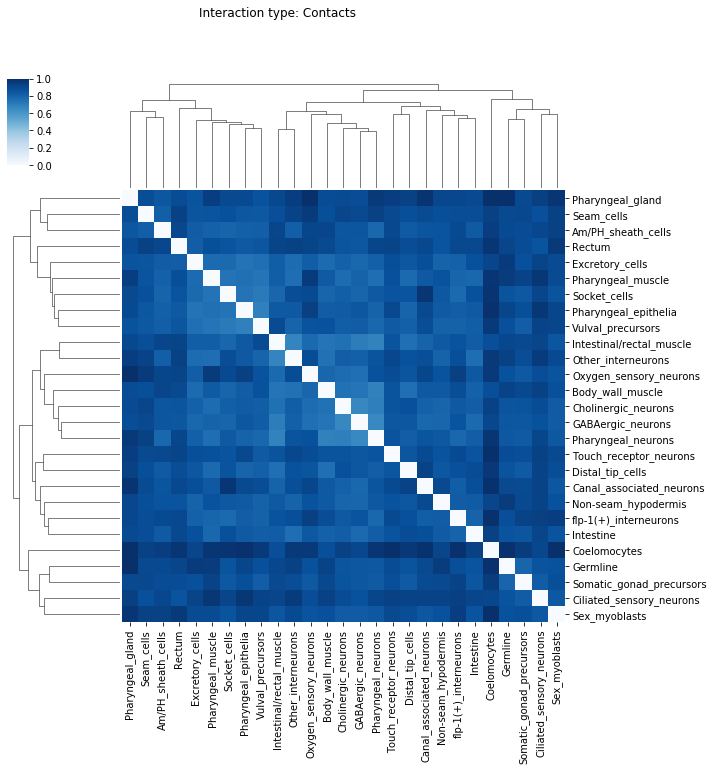

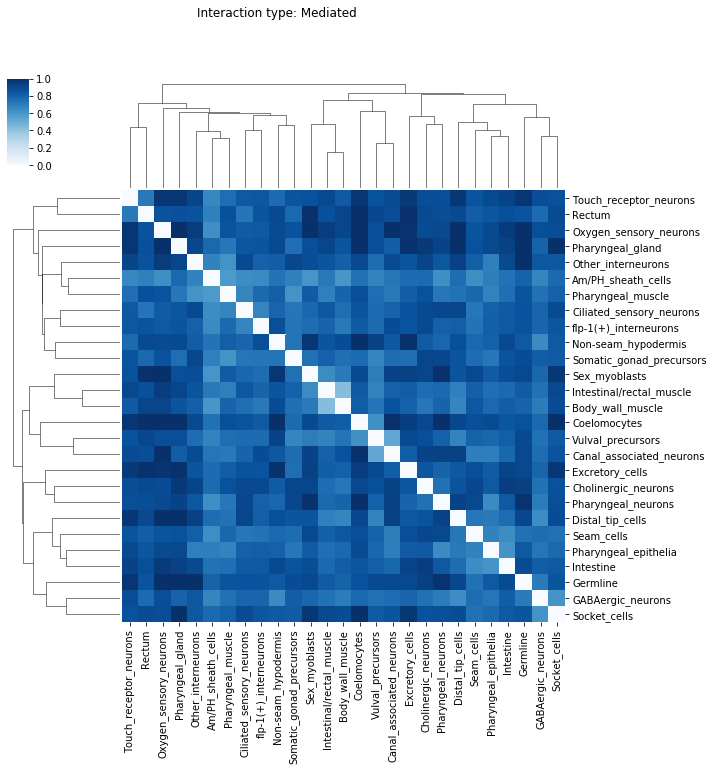

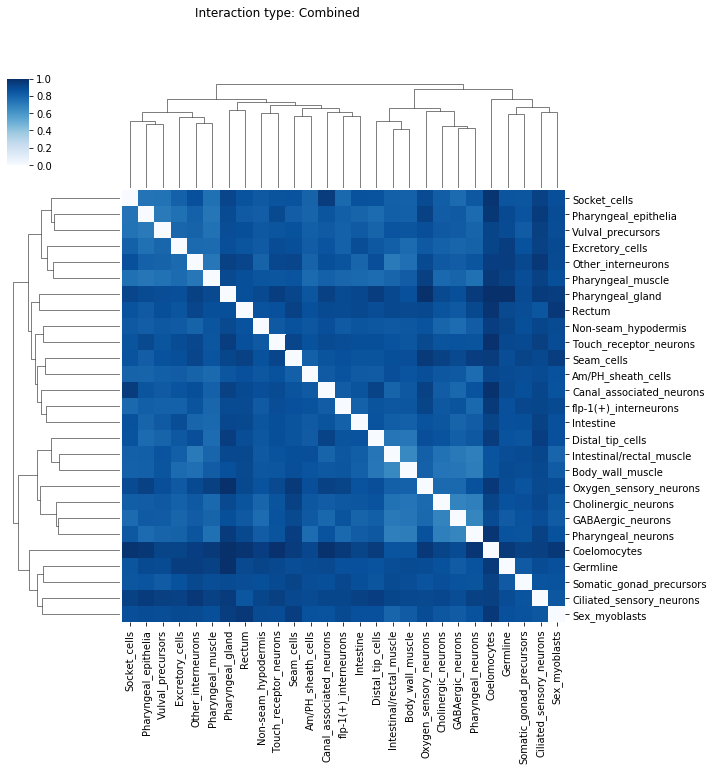

In [23]:
for interaction, distance_matrix in distance_cci.items():
    # Compute linkage
    linkage = hc.linkage(sp.distance.squareform(distance_matrix), method='ward')
    
    # Plot hierarchical clustering
    hier = sns.clustermap(distance_matrix,
                          col_linkage=linkage,
                          row_linkage=linkage,
                          cmap='Blues',
                          vmin=0,
                          vmax=1,
                          )
    hier.fig.suptitle('Interaction type: ' + interaction.capitalize()) 

# PCoA

/Users/earmingol/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.027278487694884813 and the largest is 0.8725841545683717.
  RuntimeWarning
/Users/earmingol/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section

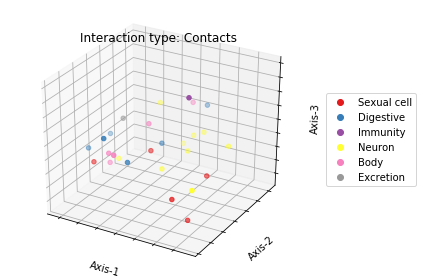

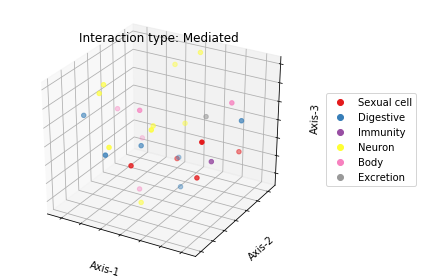

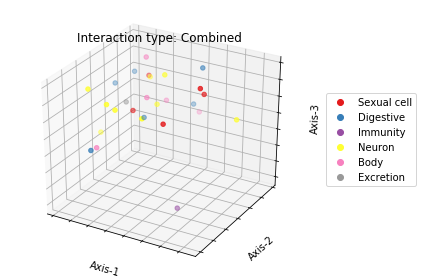

In [24]:
for interaction, distance_matrix in distance_cci.items():
    # PCoA
    ordination = skbio.stats.ordination.pcoa(distance_matrix)
    biplot = ordination.plot(df=meta, column='type', cmap='Set1',
                             axis_labels=('Axis-1','Axis-2','Axis-3'))
    plt.title('Interaction type: ' + interaction.capitalize()) 
    
    # Export data for using in Qiime2
    distskbio = skbio.DistanceMatrix(distance_matrix, ids=distance_matrix.index)
    distskbio.write(files['output_folder'] + '/{}-RSPGM_Distance_{}.txt'.format(analysis_setup['function_type'].replace('sample_', ''),
                                                                                 interaction.capitalize()))
    ordination.samples.index = distance_matrix.index
    ordination.write(files['output_folder'] + '/{}-RSPGM_Ordination_{}.txt'.format(analysis_setup['function_type'].replace('sample_', ''),
                                                                                    interaction.capitalize()))

meta.to_csv(files['output_folder'] + "/metadata.tsv", sep="\t", index=False)